## Suyash Shrivastava - George Washington University - DNSC 6290 - Natural Language Processing Final Project - Source code with interactive visualization

# Visualizing topics of discussion with the hashtag '*#FIFAWorldCup2022*' on Twitter between December 1st, 2022 till December 9th, 2022 using pyLDAvis 

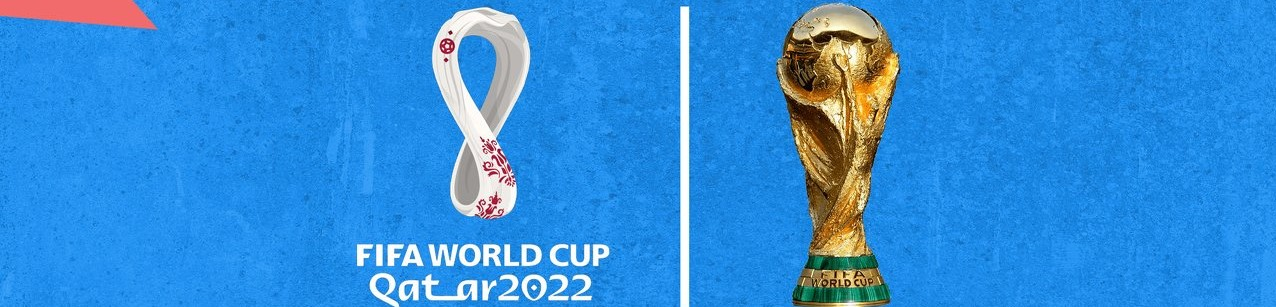

### Importing libraries required for this analysis




In [ ]:
import warnings
import csv
import pandas as pd
import random
warnings.filterwarnings('ignore',category=DeprecationWarning)
import numpy as np
import re,random,os
import seaborn as sns
import string
from pprint import pprint as pprint

### Importing spacy for basic processing, nltk for lemmatisation etc. and gensim for LDA

In [ ]:
import spacy
import nltk
from nltk.corpus import stopwords
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


### Checking if all the stop words were downloaded correctly


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Installing pyLDAvis to generate the required visualization 

In [ ]:
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Installing tweepy package to scrape tweets from Twitter 


In [ ]:
!pip install tweepy
import tweepy

### Scraping tweets from Twitter using Tweepy API

In [ ]:
## Input my twitter developer account credentials and key-secret tokens to authenticate my twitter developer account
consumer_key = 'XXYYZZ'
consumer_secret = 'XXYYZZ'
access_token = 'XXYYZZ'
access_token_secret = 'XXYYZZ'

#Using tweepy api to establish authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

# Opening/ Creating a csv file to append the tweets with the hashtag ##FIFAWorldCup2022 in local Google Colab runtime environment
csvFile = open('WorldCup2022_tweets_12.1_12.9.csv', 'a')
csvWriter = csv.writer(csvFile)

# Using tweepy.Cursor to fetch tweets only in english (including each tweet's datetime stamp) which were 
# tweeted between December 1st to December 9th 2022 with the hashtag #FIFAWorldCup2022. 
# The fetched tweets are then written in the csv file which we created earlier.
for tweet in tweepy.Cursor(api.search,q="#FIFAWorldCup2022",count=100, lang="en",since="2022-12-01", until="2022-12-09",retry_count = 5, retry_delay = 5).items():
    #print (tweet.created_at, tweet.text), 
    csvWriter.writerow([tweet.created_at, tweet.text.encode('utf-8')])

### Converting the csv file to a pandas dataframe and viewing the first few rows

In [ ]:
df=pd.read_csv('WorldCup2022_tweets_12.1_12.9.csv',encoding="ISO-8859-1")
df.head()

,2022-12-08 23:58:01,b'RT @foboclub: @Foboclubis hosting the #FIFAWORLDCUP2022 #Prediction #Giveaways with @Karmaverse_io\n\nPrize Pool:\n\xf0\x9f\x8f\x8610 x Karmaverse NFT\n\xf0\x9f\x8f\x8610 x\xe2\x80\xa6'
0,2022-12-08 23:57:24,b'RT @foboclub: @Foboclubis hosting the #FIFAW...
1,2022-12-08 23:56:30,b'RT @foboclub: @Foboclubis hosting the #FIFAW...
2,2022-12-08 23:56:07,b'RT @HathorNetwork: 1000 $HTR #GIVEAWAY! \xf0...
3,2022-12-08 23:55:42,b'RT @dushyant_singhh: FIFA World Cup\xe2\x80\...
4,2022-12-08 23:55:20,b'RT @HathorNetwork: 1000 $HTR #GIVEAWAY! \xf0...


### Getting information about the dataframe

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118322 entries, 0 to 118321
Data columns (total 2 columns):
 #   Column                                                                                                                                                                                       Non-Null Count   Dtype 
---  ------                                                                                                                                                                                       --------------   ----- 
 0   2022-12-08 23:58:01                                                                                                                                                                          118322 non-null  object
 1   b'RT @foboclub: @Foboclubis hosting the #FIFAWORLDCUP2022 #Prediction #Giveaways with @Karmaverse_io\n\nPrize Pool:\n\xf0\x9f\x8f\x8610 x Karmaverse NFT\n\xf0\x9f\x8f\x8610 x\xe2\x80\xa6'  118322 non-null  object
dtypes: object(2)


## We can see that we have 2 columns in our dataframe. In the first column we have the datetime stamp of the tweets and in the second we have the actual tweet text.

### Renaming the columns to 'Time' and 'Tweet' accordingly. Printing the new column names to confirm the changes in our dataframe.

In [ ]:
df = pd.DataFrame(df)
df.columns = ['Time', 'Tweet']
print(df.columns)

Index(['Time', 'Tweet'], dtype='object')


### Checking the information of our new dataframe.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118322 entries, 0 to 118321
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Time    118322 non-null  object
 1   Tweet   118322 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


### We can see that we have 118322 tweets as our input data for this topic modelling. Let's generate a random tweet from the dataframe.

In [ ]:
df.Tweet[random.randrange(len(df.Tweet))]

"b'This is very painful to watch. Come on #Ghana !! #FIFAWorldCup2022 https://t.co/P66NIdzrcj'"

### Viewing the text of 10 tweets.

In [ ]:
df.Tweet[:10]

0    b'RT @foboclub: @Foboclubis hosting the #FIFAW...
1    b'RT @foboclub: @Foboclubis hosting the #FIFAW...
2    b'RT @HathorNetwork: 1000 $HTR #GIVEAWAY! \xf0...
3    b'RT @dushyant_singhh: FIFA World Cup\xe2\x80\...
4    b'RT @HathorNetwork: 1000 $HTR #GIVEAWAY! \xf0...
5    b'RT @HathorNetwork: 1000 $HTR #GIVEAWAY! \xf0...
6    b'RT @SportyBet: Legends \xf0\x9f\xa4\xa9\xf0\...
7    b'RT @InfinixDesigns: #Mascot  &amp; #Gaming #...
8    b'RT @OnlinePalEng: Israeli media are attackin...
9    b'RT @HathorNetwork: 1000 $HTR #GIVEAWAY! \xf0...
Name: Tweet, dtype: object

### Cleaning the tweets/ text by removing URLs, special characters, double spaces and converting the text in lower case. Stroring the cleaned tweets and displaying 10 tweets after initial data cleaning.

In [ ]:
def remove_URL(x):
    return x.replace(r'https[a-zA-Z0-9]*',"",regex=True)

#clean tweet text
def clean_tweets(tweet_col):
    df=pd.DataFrame({'Tweet':tweet_col})
    df['Tweet']=df['Tweet'].replace(r'\'|\"|\,|\.|\?|\+|\-|\/|\=|\(|\)|\n|"', '', regex=True)
    df['Tweet']=df['Tweet'].replace("  "," ")
    df['Tweet']=df['Tweet'].replace(r'@[a-zA-Z0-9]*', '', regex=True)
    df['Tweet']=remove_URL(df['Tweet'])
    df['Tweet']=df['Tweet'].str.lower()
    
    return(df)

cleaned_tweets=clean_tweets(df.Tweet)
cleaned_tweets[:10]

,Tweet
0,brt : hosting the #fifaworldcup2022 #predicti...
1,brt : hosting the #fifaworldcup2022 #predicti...
2,brt : 1000 $htr #giveaway! \xf0\x9f\x8e\x81\n\...
3,brt _singhh: fifa world cup\xe2\x80\x99s most ...
4,brt : 1000 $htr #giveaway! \xf0\x9f\x8e\x81\n\...
5,brt : 1000 $htr #giveaway! \xf0\x9f\x8e\x81\n\...
6,brt : legends \xf0\x9f\xa4\xa9\xf0\x9f\x87\xa7...
7,brt : #mascot &amp; #gaming #logo #design\n\n...
8,brt : israeli media are attacking palestinian ...
9,brt : 1000 $htr #giveaway! \xf0\x9f\x8e\x81\n\...


### Tokenize using gensims simple_preprocess. Removed stop words and punctuations from the tweets and finally used spacy for lemmatizing the tweets.

In [ ]:
# Creating a functions to transform sentences to words
def sent_to_words(sentences, deacc=True):  # Using deacc=True removes punctuations
    for sentence in sentences:
        yield(simple_preprocess(str(sentence)))

#Creating a lemmatization fucntion
def lemmatization(texts,allowed_postags=['NOUN','ADJ','VERB','ADV']):
    """https://spacy.io/api/annotation"""
    texts_out=[]
    for sent in texts:
        doc=nlp(' '.join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Creating a list to remove all the stop words from the tweets
words_remove = ["ax","i","you","edu","s","t","m","subject","can","lines","re","what", "there",
                    "all","we","one","the","a","an","of","or","in","for","by","on","but","is","in",
                    "a","not","with","as","was","if","they","are","this","and","it","have","from","at",
                    "my","be","by","not","that","to","from","com","org","like","likes","so","said","from",
                    "what","told","over","more","other","have","last","with","this","that","such","when",
                    "been","says","will","also","where","why","would","today", "in", "on", "you", "r", "d", 
                    "u", "hw","wat", "oly", "s", "b", "ht", "rt", "p","the","th", "lol", ':']

# Creating new lists 
stop_words = set(list(stopwords.words('english') + list(string.punctuation)+words_remove))
data_words= list(sent_to_words(cleaned_tweets.Tweet.values.tolist(), deacc=False))

# Removing stopwords from the tweets
def remove_stopwords(texts, stop_words=stop_words):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words_nostops = remove_stopwords(data_words)


# Using spacy for lemmatization
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Printing 3 lemmatized words
print(data_lemmatized[3])

['spectacular', 'goal', 'wwfw']


### Creating dictionary and corpus of the words

In [ ]:
id2word= corpora.Dictionary(data_lemmatized)
texts=data_lemmatized
corpus=[id2word.doc2bow(text) for text in texts]

### Building models across a range of number of topics and alpha and generating the cohehrence value of each model in a dataframe.

In [ ]:
# Creating a function to compute coherence values
def compute_coherence_values(dictionary, corpus, texts, num_topics_range,alpha_range):
    coherence_values=[]
    model_list=[]
    for alpha in alpha_range:
        for num_topics in num_topics_range:
            lda_model= gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, alpha=alpha,num_topics=num_topics,\
                                                      per_word_topics=True)
            model_list.append(lda_model)
            coherencemodel=CoherenceModel(model=lda_model,texts=texts,dictionary=dictionary,coherence='c_v')
            coherence_values.append((alpha,num_topics,coherencemodel.get_coherence()))
    return model_list,coherence_values

#Setting the range of number of topics and alpha range
num_topics_range=[2,6,10,15]
alpha_range=[0.01,0.1,1]
model_list, coherence_values=compute_coherence_values(dictionary=id2word,corpus=corpus,texts=data_lemmatized,\
                                                      num_topics_range=num_topics_range,\
                                                     alpha_range=alpha_range)
coherence_df=pd.DataFrame(coherence_values,columns=['alpha','num_topics','coherence_value'])
coherence_df

,alpha,num_topics,coherence_value
0,0.01,2,0.421496
1,0.01,6,0.461841
2,0.01,10,0.469539
3,0.01,15,0.471435
4,0.10,2,0.421977
5,0.10,6,0.478544
6,0.10,10,0.475716
7,0.10,15,0.465573
8,1.00,2,0.362143
9,1.00,6,0.437275


### From the above coherence table, we can see that the model with alpha 0.1 and number of topics as 6 has the highest coherence value i.e. 0.478544. Also, we can see that coherence score is 0.475716 for alpha 0.1 and number of topics as 10. I want to analyze 10 topics for this analysis. Since the coherence value is between an acceptable range for num_topics as 10, we will use this model for our analysis.

### Generating a graph to plot coherence value and number of topics for each alpha value.

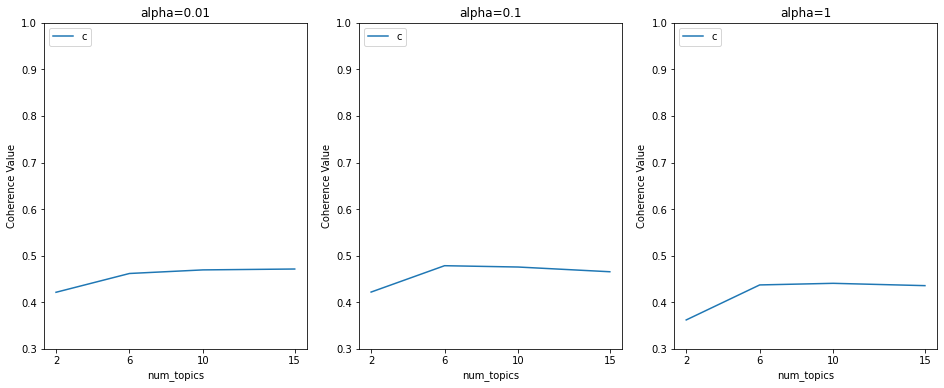

In [ ]:
# plot
def plot_coherence(coherence_df,alpha_range,num_topics_range):
    plt.figure(figsize=(16,6))
    
    for i,val in enumerate(alpha_range):
        #subolot 1/3/i
        plt.subplot(1,3,i+1)
        alpha_subset=coherence_df[coherence_df['alpha']==val]
        plt.plot(alpha_subset['num_topics'],alpha_subset['coherence_value'])
        plt.xlabel('num_topics')
        plt.ylabel('Coherence Value')
        plt.title('alpha={0}'.format(val))
        plt.ylim([0.30,1])
        plt.legend('coherence value', loc='upper left')
        plt.xticks(num_topics_range)
        
plot_coherence(coherence_df,alpha_range,num_topics_range)

### Building a LDA model with alpha=0.1 and 10 topics.

In [ ]:
lda_model= gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=10, random_state=420,\
                                          update_every=1,chunksize=100, passes=10, alpha=0.1, per_word_topics=True)

### Printing the keywords for each topic

In [ ]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.358*"fifaworldcup" + 0.204*"co" + 0.040*"score" + 0.033*"game" + '
  '0.027*"nenjoy" + 0.026*"round" + 0.016*"join" + 0.013*"brt" + 0.013*"pop" + '
  '0.010*"worldcup"'),
 (1,
  '0.084*"go" + 0.055*"group" + 0.052*"time" + 0.042*"prediction" + '
  '0.038*"qualify" + 0.035*"giveaway" + 0.033*"rap" + 0.028*"stage" + '
  '0.020*"correct" + 0.018*"menzien"'),
 (2,
  '0.153*"football" + 0.125*"match" + 0.019*"history" + 0.016*"odd" + '
  '0.015*"miss" + 0.014*"bet" + 0.013*"unique" + 0.012*"already" + '
  '0.011*"african" + 0.010*"spot"'),
 (3,
  '0.080*"flag" + 0.066*"city" + 0.048*"celebrate" + 0.043*"moment" + '
  '0.035*"song" + 0.035*"congratulation" + 0.027*"good" + '
  '0.025*"spotifycorrupt" + 0.022*"support" + 0.019*"well"'),
 (4,
  '0.179*"team" + 0.097*"winner" + 0.060*"win" + 0.052*"predict" + '
  '0.035*"kingandprince" + 0.034*"play" + 0.033*"give" + 0.025*"follow" + '
  '0.022*"know" + 0.020*"teamuruguay"'),
 (5,
  '0.166*"link" + 0.053*"back" + 0.047*"spotifywrappe"

### Checking the coherence score.

In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.4823103818679086


### Visualizing the topics using pyLDAvis to see the identified topics and the top 30 most used terms in that particular topic.

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.108447  0.403729       1        1  13.386920
3      0.010668 -0.159014       2        1  11.861178
2      0.027045 -0.042517       3        1  11.296317
4      0.104762 -0.011457       4        1   9.768026
9      0.031721 -0.077422       5        1   9.568590
7      0.033291 -0.052621       6        1   9.514171
5      0.024832 -0.037342       7        1   9.190267
6      0.023625 -0.040648       8        1   8.955224
1      0.060739 -0.054109       9        1   8.769216
8     -0.425130  0.071401      10        1   7.690091, topic_info=               Term          Freq         Total Category  logprob  loglift
0      fifaworldcup  29602.000000  29602.000000  Default  30.0000  30.0000
2001             co  16841.000000  16841.000000  Default  29.0000  29.0000
1877           exit  11027.000000  11027.000000  Default  28.0000  28.0000
1866          react  10759.000000  10759.000000  Default  27.0000  27.0000
79             team  10774.000000  10774.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
676           event    220.907535    221.839416  Topic10  -5.3708   2.5610
25339   entitlement    233.639850    234.630616  Topic10  -5.3148   2.5610
11               xf    218.396553    219.328084  Topic10  -5.3823   2.5610
1125          scene    213.224501    214.156701  Topic10  -5.4062   2.5609
756            name    202.523587    203.455806  Topic10  -5.4577   2.5606

[339 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
1161       3  0.998831     action
760        1  0.998360      actor
810        4  0.997979    advance
76         3  0.999549    african
1389       3  0.999060      ahead
...      ...       ...        ...
695        5  0.997527       year
2492       1  0.998528  yesterday
32084      1  0.023659       zigi
32084      8  0.005915       zigi
32084      9  0.967069       zigi

[330 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 5, 10, 8, 6, 7, 2, 9])